In [6]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import json


In [7]:
CHESSBOARD_SIZE = (8, 6)
folder_path = 'chessboard_dataset'

images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpeg')]

In [8]:
imgpts, objpts = [], []

objp = np.zeros((CHESSBOARD_SIZE[0] * CHESSBOARD_SIZE[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:CHESSBOARD_SIZE[0],0:CHESSBOARD_SIZE[1]].T.reshape(-1,2)

In [9]:
image_size = None

for i in images:
    img = cv2.imread(i)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, CHESSBOARD_SIZE, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    if ret == True:
        objpts.append(objp)
        imgpts.append(corners)
        img = cv2.drawChessboardCorners(img, CHESSBOARD_SIZE, corners, ret)
    
    image_size = gray.shape[::-1]

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, image_size, None, None)

3a

In [10]:
print("Intrinsic Camera Matrix:")
print(mtx)

print("Focal Lengths:")
print(mtx[0,0], mtx[1,1])

print("Skew Parameter:")
print(mtx[0,1])

print("Principal Point:")
print(mtx[0,2], mtx[1,2])

Intrinsic Camera Matrix:
[[955.98313094   0.         368.88206131]
 [  0.         956.77497522 648.82867526]
 [  0.           0.           1.        ]]
Focal Lengths:
955.983130942084 956.7749752185975
Skew Parameter:
0.0
Principal Point:
368.8820613141149 648.8286752606324


3b

In [11]:
rotation_matrices = []

for i in rvecs:
    matrix = cv2.Rodrigues(i)[0]
    rotation_matrices.append(matrix)

In [12]:
print("-" * 10, "First Image", "-" * 10)
print("Rotation Matrix:")
print(rotation_matrices[0])
print("Translation Vectors:")
print(tvecs[0])

print("-" * 10, "Second Image", "-" * 10)
print("Rotation Matrix:")
print(rotation_matrices[1])
print("Translation Vectors:")
print(tvecs[1])

---------- First Image ----------
Rotation Matrix:
[[ 0.99696989  0.01389117 -0.076538  ]
 [-0.0249913   0.98896274 -0.14604153]
 [ 0.07366454  0.14751179  0.98631324]]
Translation Vectors:
[[-3.93539962]
 [-3.577326  ]
 [14.65560174]]
---------- Second Image ----------
Rotation Matrix:
[[ 0.99828989  0.05396736 -0.02246819]
 [-0.05074304  0.99081849  0.12531503]
 [ 0.02902482 -0.12396062  0.99186255]]
Translation Vectors:
[[-4.36904499]
 [-1.41695139]
 [15.81221439]]


3c

In [13]:
print("Radial Distortion Coefficients:")
print(dist[0][0], dist[0][1], dist[0][4])

Radial Distortion Coefficients:
0.2156535127267817 -1.0390456869432543 1.5863503096888527


In [14]:
def board_corners(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, CHESSBOARD_SIZE, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    if ret == True:
        return True, corners
    return False, None

In [15]:
radial_dist = dist.copy()
radial_dist[0][2] = 0
radial_dist[0][3] = 0

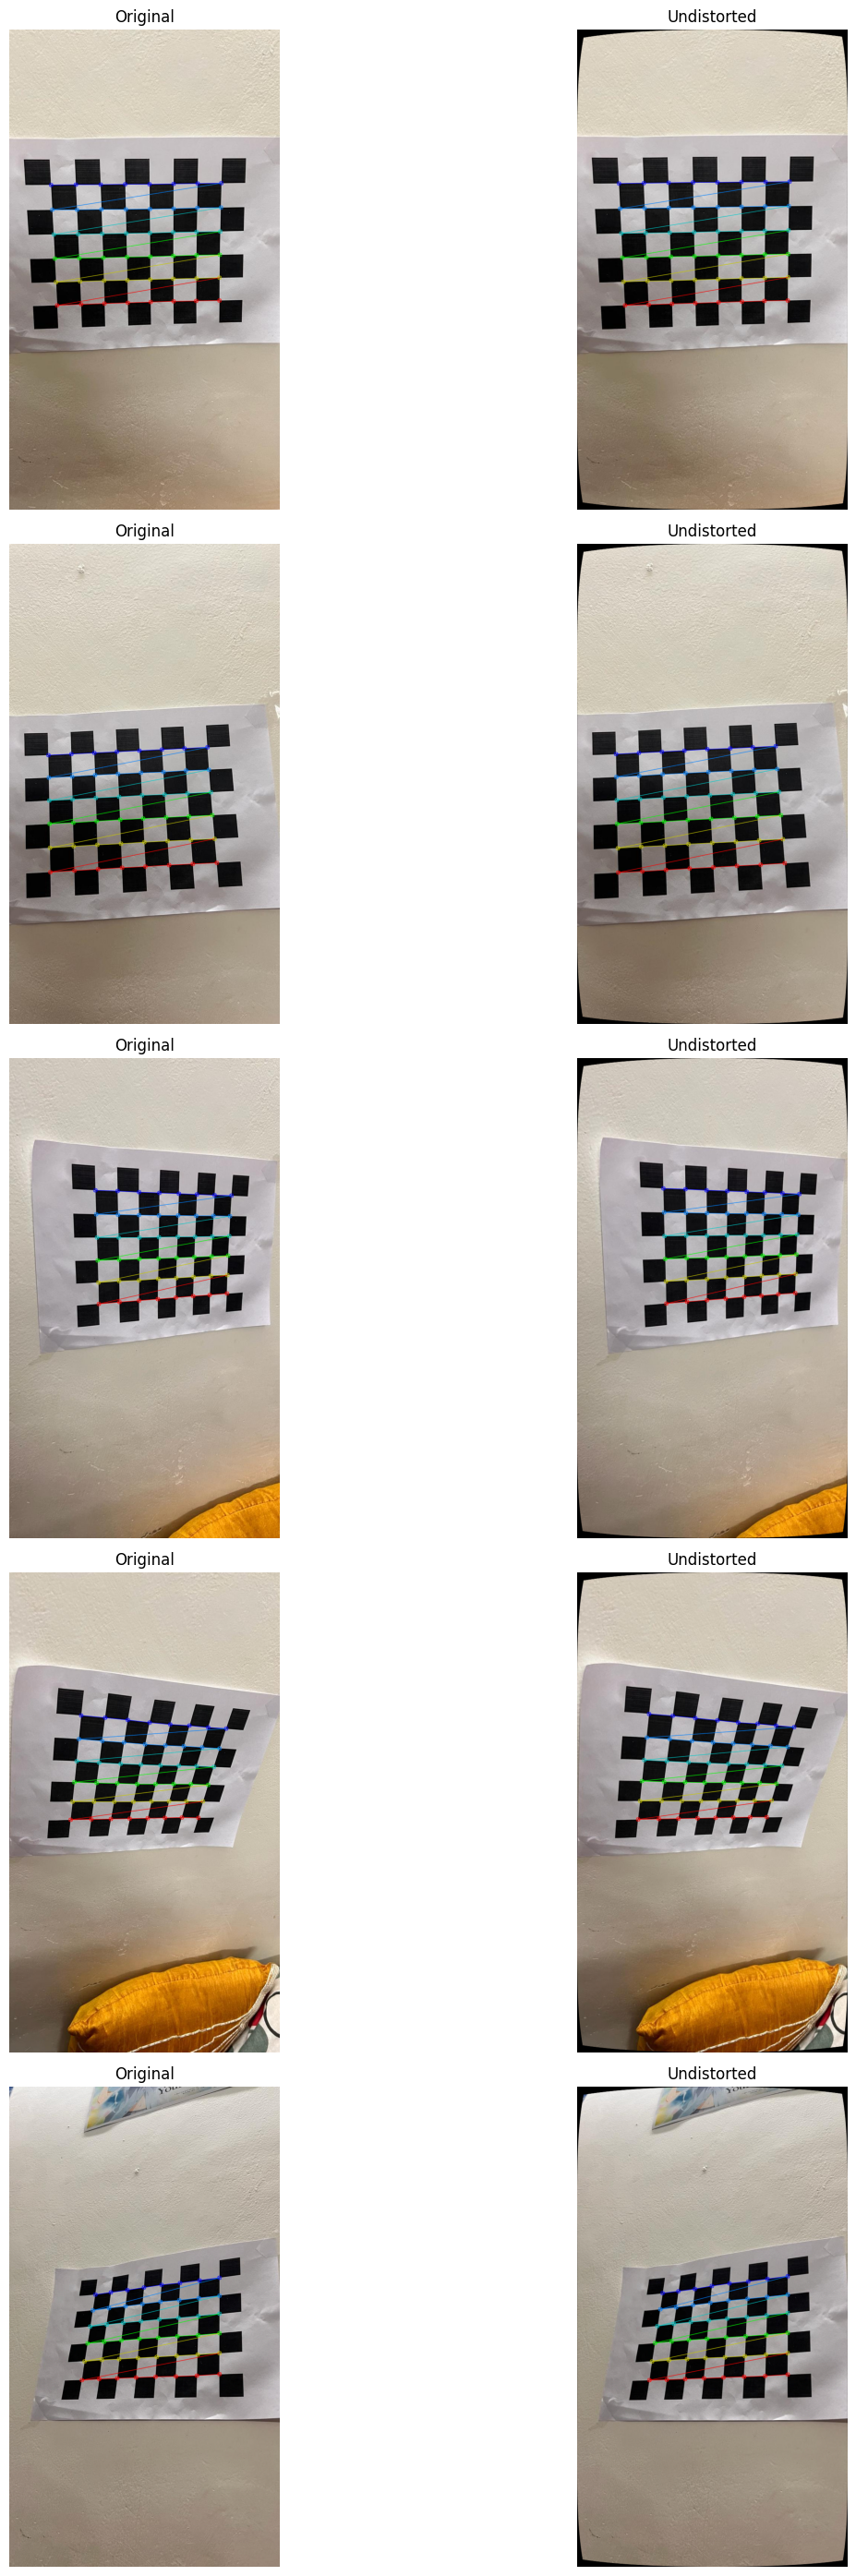

In [16]:
plt.figure(figsize=(16, 28))

for i, img_path in enumerate(images[:5]):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    h, w = img.shape[:2]
    new_mtx, roi = cv2.getOptimalNewCameraMatrix(mtx, radial_dist, (w, h), 1, (w, h))
    undistorted = cv2.undistort(img, mtx, radial_dist, None, new_mtx)
    
    ret, corners = board_corners(img)
    ret_undistorted, corners_undistorted = board_corners(undistorted)

    if ret:
        img = cv2.drawChessboardCorners(img, CHESSBOARD_SIZE, corners, ret)
    if ret_undistorted:
        undistorted = cv2.drawChessboardCorners(undistorted, CHESSBOARD_SIZE, corners_undistorted, ret_undistorted)

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(img)
    plt.title(f"Original")
    plt.axis('off')

    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(undistorted)
    plt.title(f"Undistorted")
    plt.axis('off')

plt.tight_layout()

3d

In [17]:
errors = []

for i in range(len(objpts)):
    imgpts_proj, _ = cv2.projectPoints(objpts[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpts[i], imgpts_proj, cv2.NORM_L2) / len(imgpts_proj)
    errors.append(error)

print(f"Average Reprojection Error: {np.mean(errors)}")
print(f"Standard Deviation of Reprojection Error: {np.std(errors)}")


Average Reprojection Error: 0.07498802315303951
Standard Deviation of Reprojection Error: 0.023956747838967504


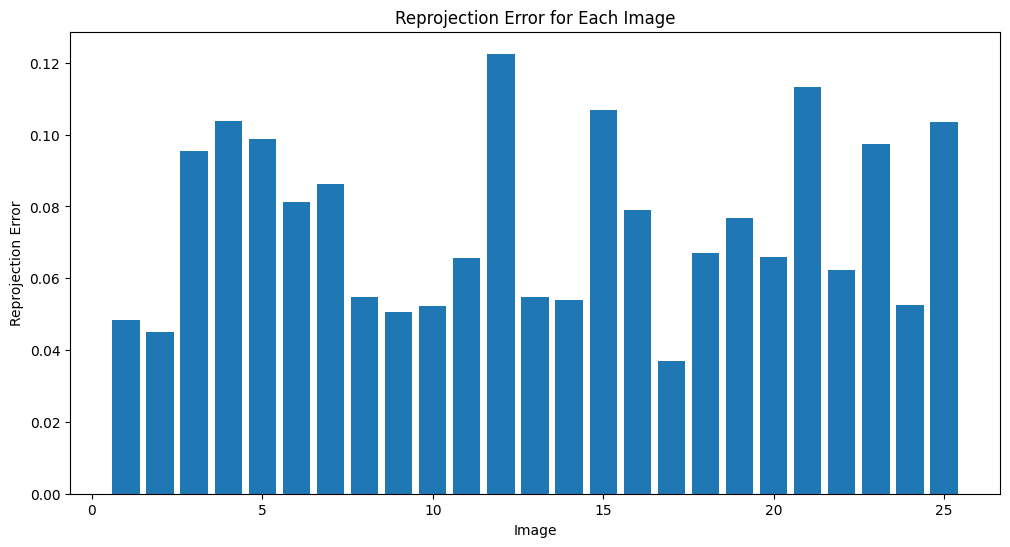

In [18]:
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(errors) + 1), errors)
plt.xlabel('Image')
plt.ylabel('Reprojection Error')
plt.title('Reprojection Error for Each Image')
plt.show()


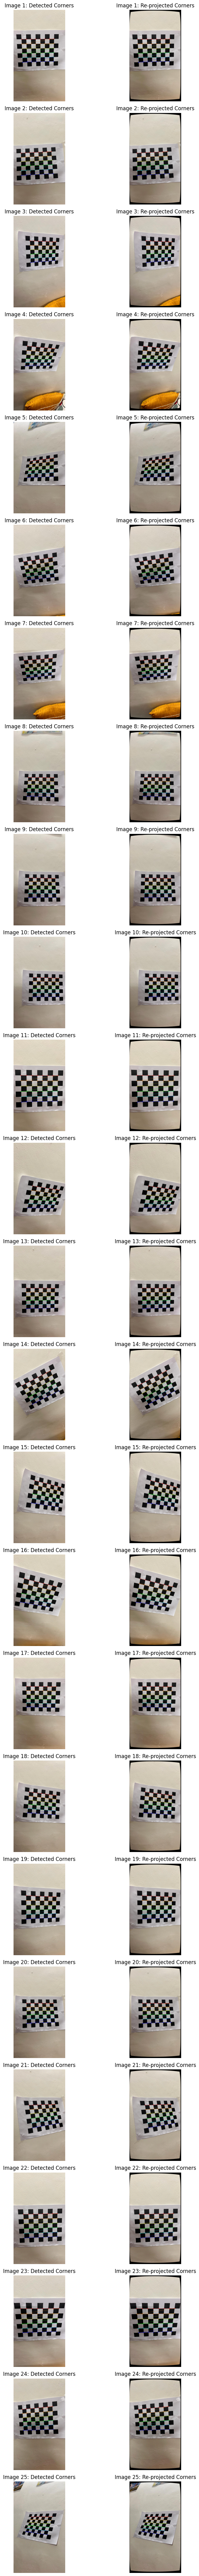

In [19]:
plt.figure(figsize=(10, 84))

for i in range(len(objpts)):
    img = cv2.imread(images[i])

    undistorted = cv2.undistort(img, mtx, dist)
    
    reprojected_corners, _ = cv2.projectPoints(objpts[i], rvecs[i], tvecs[i], mtx, dist)

    img_detected = img.copy()
    corners_reshaped = imgpts[i].reshape(-1, 1, 2).astype(np.float32)
    cv2.drawChessboardCorners(img_detected, CHESSBOARD_SIZE, corners_reshaped, True)

    img_reprojected = undistorted.copy()
    reprojected_corners_reshaped = reprojected_corners.reshape(-1, 1, 2).astype(np.float32)
    cv2.drawChessboardCorners(img_reprojected, CHESSBOARD_SIZE, reprojected_corners_reshaped, True)

    img_detected_rgb = cv2.cvtColor(img_detected, cv2.COLOR_BGR2RGB)
    img_reprojected_rgb = cv2.cvtColor(img_reprojected, cv2.COLOR_BGR2RGB)

    plt.subplot(25, 2, 2*i + 1)
    plt.imshow(img_detected_rgb)
    plt.title(f"Image {i+1}: Detected Corners")
    plt.axis('off')

    plt.subplot(25, 2, 2*i + 2)
    plt.imshow(img_reprojected_rgb)
    plt.title(f"Image {i+1}: Re-projected Corners")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [20]:
normals = []
for idx, i in enumerate(rotation_matrices):
    normals.append(i[2])

In [21]:
for i in range(len(normals)):
    print(f"Image {i} normal: {normals[i]}")

Image 0 normal: [0.07366454 0.14751179 0.98631324]
Image 1 normal: [ 0.02902482 -0.12396062  0.99186255]
Image 2 normal: [0.39028616 0.20110607 0.8984615 ]
Image 3 normal: [0.3975825  0.48895515 0.77643481]
Image 4 normal: [-0.35645372 -0.40251267  0.84316327]
Image 5 normal: [-0.09063589  0.31180444  0.94581347]
Image 6 normal: [0.09108273 0.51319171 0.85342733]
Image 7 normal: [-0.07651364 -0.21772877  0.97300557]
Image 8 normal: [ 0.09474059 -0.20108647  0.97498126]
Image 9 normal: [ 0.14371054 -0.07803141  0.98653858]
Image 10 normal: [0.10776904 0.08546547 0.99049558]
Image 11 normal: [0.43861018 0.22649536 0.86966716]
Image 12 normal: [0.13576403 0.10450709 0.98521388]
Image 13 normal: [-0.03855277  0.28664423  0.95726108]
Image 14 normal: [ 0.35155881 -0.07742426  0.93295867]
Image 15 normal: [0.24090876 0.31530029 0.91790451]
Image 16 normal: [-0.03398246  0.11049903  0.9932951 ]
Image 17 normal: [ 0.21701635 -0.08703717  0.97228002]
Image 18 normal: [0.27043767 0.09624743 0.95

In [22]:
f_x = float(mtx[0, 0]) 
f_y = float(mtx[1, 1])  
skew = float(mtx[0, 1])  
c_x = float(mtx[0, 2])
c_y = float(mtx[1, 2])

radial_k1 = float(radial_dist[0][0])
radial_k2 = float(radial_dist[0][1])
radial_k3 = float(radial_dist[0][4])

mean_reprojection = float(np.mean(errors)) 
std_dev_reprojection = float(np.std(errors)) 

extrinsic_parameters_data = [
    {
        "image_id": 1,
        "rotation_matrix": rotation_matrices[0].tolist(),  
        "translation_vector": tvecs[0].flatten().tolist()  
    },
    {
        "image_id": 2,
        "rotation_matrix": rotation_matrices[1].tolist(),  
        "translation_vector": tvecs[1].flatten().tolist()
    },
]

data = {
    "intrinsic_parameters": {
        "focal_length": [f_x, f_y],
        "skew": skew,
        "principal_point": [c_x, c_y]
    },
    "extrinsic_parameters": extrinsic_parameters_data,
    "radial_distortion_coefficients": [radial_k1, radial_k2, radial_k3],
    "reprojection_errors": {
        "mean_error": mean_reprojection,
        "std_dev": std_dev_reprojection
    }
}

json_output = json.dumps(data, indent=4)
print(json_output)

with open("2021555_parameters.json", "w") as f:
    json.dump(data, f, indent=4)


{
    "intrinsic_parameters": {
        "focal_length": [
            955.983130942084,
            956.7749752185975
        ],
        "skew": 0.0,
        "principal_point": [
            368.8820613141149,
            648.8286752606324
        ]
    },
    "extrinsic_parameters": [
        {
            "image_id": 1,
            "rotation_matrix": [
                [
                    0.9969698943534995,
                    0.013891168316436543,
                    -0.07653799837712313
                ],
                [
                    -0.024991300509346077,
                    0.9889627428309221,
                    -0.14604152899497794
                ],
                [
                    0.07366454134536937,
                    0.14751179185117322,
                    0.9863132396015134
                ]
            ],
            "translation_vector": [
                -3.935399618357528,
                -3.577326002706815,
                14.655601738140733
       